In [1]:
import solve_mis
import scipy
import networkx as nx
import numpy as np
import qiskit as qk
from qiskit.circuit import ControlledGate
from qiskit.circuit.library.standard_gates import XGate
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler import PassManager

from networkx.generators.ego import ego_graph

from utils.graph_funcs import *
from utils.helper_funcs import *

In [2]:
simulator = qk.Aer.get_backend('aer_simulator_statevector')

In [3]:
circ = qk.QuantumCircuit(2)
circ.h(circ.qubits)
circ.add_register(qk.AncillaRegister(1, 'anc'))
circ.save_statevector()
circ.draw()

┌───┐ ░ 
  q_0: ┤ H ├─░─
       ├───┤ ░ 
  q_1: ┤ H ├─░─
       └───┘ ░ 
anc_0: ──────░─
             ░

In [4]:
res = simulator.run(circ, shots=1000).result()
res.get_counts()

{'000': 0.25, '001': 0.25, '010': 0.25, '011': 0.25}

Optimal: ('01000011101101100110', 10)


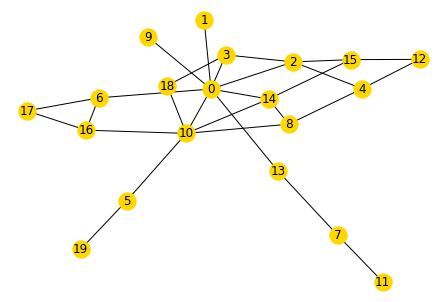

In [13]:
N = 20
connected = False
while not connected:
    G = nx.erdos_renyi_graph(N, 0.1)
    connected = nx.is_connected(G)
opt = brute_force_search(G)
print('Optimal:', opt)
nx.draw_spring(G, with_labels=True, node_color='gold')

In [14]:
init_state = '0'*N
num_partial_mixers = 5
max_node_dist = 2
mis_soln, history = solve_mis.quantum_local_search(init_state, G, num_partial_mixers, max_node_dist, verbose=1)
print('Solution: {}, Hamming weight = {}, Approximation Ratio = {}, Is a valid IS: {}'.format(
    mis_soln, hamming_weight(mis_soln), hamming_weight(mis_soln) / opt[1], is_indset(mis_soln, G, little_endian=False)))

---------- Iteration: 1 ----------
Stopping condition: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Selected node: 5
Current mis state: 00000000000000000000
	Current Hot Nodes: [19, 5, 10]
	Num qubits = 8, Num params = 4
	qubits_to_nodes: {0: 0, 1: 5, 2: 8, 3: 10, 4: 14, 5: 16, 6: 18, 7: 19}
	nodes_to_qubits: {0: 0, 5: 1, 8: 2, 10: 3, 14: 4, 16: 5, 18: 6, 19: 7}
	Optimal cost: -2.0
	Optimal hot nodes: [19, 10, 5]
	Most probable bitstring: 10001000
	Previous mis: 00000000000000000000
	Updated mis:  00000000001000000001

---------- Iteration: 2 ----------
Stopping condition: [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1]
Selected node: 4
Current mis state: 00000000001000000001
	Current Hot Nodes: [4, 2, 12, 15]
	Num qubits = 9, Num params = 5
	qubits_to_nodes: {0: 0, 1: 2, 2: 3, 3: 4, 4: 8, 5: 10, 6: 12, 7: 14, 8: 15}
	nodes_to_qubits: {0: 0, 2: 1, 3: 2, 4: 3, 8: 4, 10: 5, 12: 6, 14: 7, 15: 8}
	Optimal cost: -3.00001
	Optimal hot nodes: [4, 2, 12, 15]
	Most 

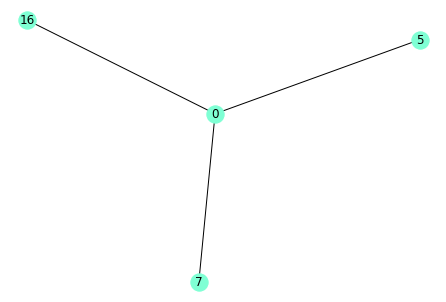

In [34]:
induced_G = ego_graph(G, 0, radius=1, center=True)
nx.draw_spring(induced_G, with_labels=True, node_color='aquamarine')

In [30]:
init_node = 2
num_partial_mixers = 5
max_node_dist=2
cur_init_state = '0'*len(G.nodes)

# Select the nodes to hit with partial mixers
hot_nodes = []
k = 1
candidates = []
print('current init state:', cur_init_state, '\n')
while len(hot_nodes) < num_partial_mixers and k <= max_node_dist:
    print('k =', k, ', hot nodes:', hot_nodes, ', candidates:', candidates)
    # Get the graph induced by the init_node and all neighbors up to
    # distance k edges away
    induced_G = ego_graph(G, init_node, radius=k, center=True)
    print('induced graph nodes:', list(induced_G.nodes))
    
    # Update the candidates list
    for node in induced_G.nodes:
        # All neighbors should be within the induced graph
        if node not in hot_nodes and node not in candidates and induced_G.degree(node) == G.degree(node):
            # None of the neighbors should be turned on
            if not any([cur_init_state[n] == '1' for n in list(induced_G[node]) + [node]]):
                candidates.append(node)
    print('Candidates after update:', candidates)

    # Check the nodes in the candidates list, if all of a node's neighbors are contained in the
    # induced graph, then add it to the list of hot nodes
    print('Checking candidates:')
    for node in candidates:
        print('\t', node)
        if induced_G.degree(node) == G.degree(node):
            hot_nodes.append(node)
            print('\tAdding!')
        else:
            print('\tSkipping...')
        
        if len(hot_nodes) >= num_partial_mixers:
            print('\tBreaking')
            break
            
    # Clean up the candidates list
    candidates = [node for node in candidates if node not in hot_nodes]
    
    # Update the candidates list with all nodes at the current k-level that weren't added in this round.
    # This helps keep the hot nodes close to the initial node in terms of k-distance
    for node in induced_G.nodes:
        if node not in hot_nodes and node not in candidates:
            if not any([cur_init_state[n] == '1' for n in list(G[node]) + [node]]):
                candidates.append(node)

    # increase the radius of the induced graph
    k += 1
    print()
print('Current Hot Nodes:', hot_nodes)

current init state: 00000000000000000000 

k = 1 , hot nodes: [] , candidates: []
induced graph nodes: [2, 5]
Candidates after update: [2]
Checking candidates:
	 2
	Adding!

k = 2 , hot nodes: [2] , candidates: [5]
induced graph nodes: [0, 2, 5, 12, 17, 19]
Candidates after update: [5]
Checking candidates:
	 5
	Adding!

Current Hot Nodes: [2, 5]


In [18]:
def gen_qlsa(circuit_G, init_state, hot_nodes, params, qubits_to_nodes, nodes_to_qubits,
             barriers=1, decompose_level=1, verbose=0):

    nq = len(circuit_G.nodes)

    # Circuit construction
    circ = qk.QuantumCircuit(nq, name='q')

    # Add an ancilla qubit for implementing the mixer unitaries
    anc_reg = qk.AncillaRegister(1, 'anc')
    circ.add_register(anc_reg)

    # Initialize any qubits that have already been flipped to |1>
    # init_state lists the graph nodes in big endian order:
    #    n_0, n_1, ..., n_N
    for qubit in range(nq):
        if init_state[qubits_to_nodes[qubit]] == '1':
            circ.x(qubit)
            
    if barriers > 0:
        circ.barrier()

    # check the number of variational parameters
    assert (len(params) == len(hot_nodes) + 1),"Incorrect number of parameters!"

    # parse the given parameter list into alphas (for the mixers) and
    # gamma (for the drivers)
    alphas = params[:-1]
    gamma = params[-1]

    # Apply partial mixers to the hot nodes
    for alpha, hot_node in zip(alphas, hot_nodes):
        
        qubit = nodes_to_qubits[hot_node]
        neighbors = list(circuit_G.neighbors(hot_node))
        qubit_neighbors = [nodes_to_qubits[n] for n in neighbors]

        if verbose > 0:
            print('node:', hot_node, 'neighbors:', neighbors, 'qubit:', qubit, 'qubit neighbors:', qubit_neighbors)

        # The partial mixer unitary consists of a multi-controlled Toffoli gate, with open-controls on q's neighbors,
        # a controlled X rotation on the hot qubit, and another multi-controlled Toffoli for uncompute
        ctrl_qubits = [circ.qubits[i] for i in qubit_neighbors]
        if decompose_level > 0:
            # Qiskit has bugs when attempting to simulate custom controlled gates.
            # Instead, wrap a regular multi-controlled toffoli with X-gates targetting the ancilla qubit.
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
            circ.mcx(ctrl_qubits, circ.ancillas[0])
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
                
            # The new AerSimulator is unable to simulate crx gates, so use a CU gate instead
            circ.cu3(2*alpha, -np.pi/2, np.pi/2, circ.ancillas[0], circ.qubits[qubit])
        
            # Uncompute the parity
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
            circ.mcx(ctrl_qubits, circ.ancillas[0])
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
        else:
            # Define a custom multi-controlled Toffoli
            mc_toffoli = ControlledGate('mc_toffoli', len(neighbors)+1, [], num_ctrl_qubits=len(neighbors),
                                        ctrl_state='0'*len(neighbors), base_gate=XGate())
            
            # Compute parity
            circ.append(mc_toffoli, ctrl_qubits + [circ.ancillas[0]])
            # Controlled Rotation
            circ.crx(2*alpha, circ.ancillas[0], circ.qubits[qubit])
            # Uncompute parity
            circ.append(mc_toffoli, ctrl_qubits + [circ.ancillas[0]])


        if barriers > 1:
            circ.barrier()

    if barriers == 1:
        circ.barrier()
    
    # Apply the phase separator unitary
    circ.rz(2*gamma, circ.qubits)

    if barriers >= 1:
        circ.barrier()

    if decompose_level > 1:
        basis_gates = ['rz', 'x', 'h', 'sx', 'cu3', 'mcx', 'cx', 't', 'tdg']
        pass_ = Unroller(basis_gates)
        pm = PassManager(pass_)
        circ = pm.run(circ)

    return circ

In [19]:
print('Hot nodes:', hot_nodes)

# The last induced Graph is the one we need to construct the circuit
num_qubits = len(induced_G.nodes)
print('Num qubits:', num_qubits)

# Make a map between qubits and nodes
nodes = list(induced_G.nodes)
print('Nodes:', nodes)
qubits_to_nodes = {q : nodes[q] for q in range(num_qubits)}
nodes_to_qubits = {qubits_to_nodes[q] : q for q in qubits_to_nodes.keys()}
print('qubits_to_nodes:', qubits_to_nodes)
print('nodes_to_qubits:', nodes_to_qubits)

params = np.arange(1,len(hot_nodes) + 2)
ansatz = gen_qlsa(induced_G, cur_init_state, hot_nodes, params, qubits_to_nodes, nodes_to_qubits,
                  barriers=2, decompose_level=1, verbose=1)
print()
print(ansatz.draw(fold=160))

Hot nodes: [0, 16, 5, 7, 2]
Num qubits: 12
Nodes: [0, 2, 5, 6, 7, 11, 12, 13, 14, 16, 17, 19]
qubits_to_nodes: {0: 0, 1: 2, 2: 5, 3: 6, 4: 7, 5: 11, 6: 12, 7: 13, 8: 14, 9: 16, 10: 17, 11: 19}
nodes_to_qubits: {0: 0, 2: 1, 5: 2, 6: 3, 7: 4, 11: 5, 12: 6, 13: 7, 14: 8, 16: 9, 17: 10, 19: 11}
node: 0 neighbors: [5, 7, 16] qubit: 0 qubit neighbors: [2, 4, 9]
node: 16 neighbors: [0, 6, 11, 12, 14] qubit: 9 qubit neighbors: [0, 3, 5, 6, 8]
node: 5 neighbors: [0, 2, 12, 17, 19] qubit: 2 qubit neighbors: [0, 1, 6, 10, 11]
node: 7 neighbors: [0, 6, 13, 17] qubit: 4 qubit neighbors: [0, 3, 7, 10]
node: 2 neighbors: [5] qubit: 1 qubit neighbors: [2]

        ░                ┌────────────────┐                ░ ┌───┐           ┌───┐       ┌───┐     ┌───┐ ░ ┌───┐     ┌───┐      ┌───┐                 ┌───┐ ░ »
  q_0: ─░────────────────┤ U3(2,-π/2,π/2) ├────────────────░─┤ X ├──■────────┤ X ├───────┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├──────┤ X ├──────────────■──┤ X ├─░─»
        ░                └─────

/Users/teague/qEnv/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).


In [20]:
ansatz.save_statevector()

In [21]:
simulator = qk.Aer.get_backend('aer_simulator_statevector')
result = simulator.run(ansatz).result()
sv = qk.quantum_info.Statevector(result.get_statevector(ansatz))
probs = strip_ancillas(sv.probabilities_dict(decimals=5), ansatz)
print(probs)

{'000000000000': 0.0017, '000000000001': 0.05697, '000000000010': 0.01947, '000000000011': 0.6511, '000000000100': 0.00043, '000000010000': 0.00228, '000000010010': 0.0261, '000000010100': 0.00058, '001000000000': 0.00813, '001000000010': 0.09294, '001000000100': 0.00205, '001000010000': 0.0109, '001000010010': 0.12459, '001000010100': 0.00275}


In [22]:
avg_cost = 0
for sample in probs.keys():
    x = [int(bit) for bit in list(sample)]
    avg_cost += probs[sample] * sum(x)
print(avg_cost)

2.0366400000000002


In [23]:
def f(params):
    circ = gen_qlsa(induced_G, cur_init_state, hot_nodes, params, qubits_to_nodes, nodes_to_qubits,
                    barriers=0, decompose_level=1, verbose=0)
    
    circ.save_statevector()
    
    result = simulator.run(circ).result()
    sv = qk.quantum_info.Statevector(result.get_statevector(circ))
    probs = strip_ancillas(sv.probabilities_dict(decimals=5), circ)
    
    avg_cost = 0
    for sample, val in probs.items():
        x = [int(bit) for bit in list(sample)]
        avg_cost += val * sum(x)
        
    return -avg_cost

In [24]:
out = scipy.optimize.minimize(f, x0=np.random.uniform(low=0.0, high=2*np.pi, size=len(hot_nodes)+1), method='COBYLA')
print(out)

     fun: -2.99966
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 91
  status: 1
 success: True
       x: array([6.28419751, 1.56644555, 4.84288798, 4.71515063, 1.70622204,
       3.02446954])


In [25]:
opt_params = out['x']
opt_cost = out['fun']
print('Optimal Cost:', opt_cost)

opt_circ = gen_qlsa(induced_G, cur_init_state, hot_nodes, opt_params, qubits_to_nodes, nodes_to_qubits,
                    barriers=0, decompose_level=1, verbose=0)
opt_circ.save_statevector()
result = simulator.run(opt_circ).result()
sv = qk.quantum_info.Statevector(result.get_statevector(opt_circ))
probs = strip_ancillas(sv.probabilities_dict(decimals=5), opt_circ)

sorted_probs = sorted([(key, val) for key, val in probs.items()], key=lambda tup: tup[1], reverse=True)
print(sorted_probs)
most_likely_str = sorted_probs[0][0]
print('Most probable bitstring:', most_likely_str)

Optimal Cost: -2.99966
[('001000010100', 0.98304), ('001000010010', 0.01662), ('001000010000', 0.00031), ('000000010100', 2e-05), ('001000000100', 1e-05)]
Most probable bitstring: 001000010100


In [26]:
# update the current initial state with the result of the local search
print('Previous cur_init_state:', cur_init_state)
temp_state = list(cur_init_state)
for qubit, bit in enumerate(reversed(most_likely_str)):
    temp_state[qubits_to_nodes[qubit]] = bit
cur_init_state = ''.join(temp_state)
print('Updated cur_init_state:', cur_init_state)

Previous cur_init_state: 00000000000000000000
Updated cur_init_state: 00000101000000001000


In [27]:
stopping_condition = [0 for _ in range(len(G.nodes))]
print(stopping_condition)

# update the stopping condition by turning all bits to 1 if they OR a neighbor were switched on
for node, bit in enumerate(cur_init_state):
    if bit == '1':
        for n in list(G[node]) + [node]:
            stopping_condition[n] = 1
print(stopping_condition)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1]


In [28]:
# Select a new initial node
init_node = np.random.choice([node for node, val in enumerate(stopping_condition) if val == 0])
print(init_node)

8
